# Adaptive Computation Demo: Visualizing Attention

This notebook demonstrates the Adaptive Computation (AC) allocation strategy in action.
We'll visualize which particles receive more rejuvenation moves ("attention") during inference,
using **line thickness** to indicate the allocation each particle received.

In [1]:
using Gen
using Plots
using Statistics
using Colors  # For color interpolation (weighted_color_mean, colorant)

include("../src/inference/particle_filter.jl")
include("../src/covariance.jl")
include("../src/data_gen.jl")

get_data

## Generate Sample Data

First, let's generate some data from a GP with a randomly sampled kernel.

Ground truth kernel: Mul(Mul(Sin(0.8182858975001956, 0.9889492854538846), Lin(0.1557203918978014, 0.3635701779370447), 3), Lin(0.045713591264002096, 0.23797653176942124), 5)


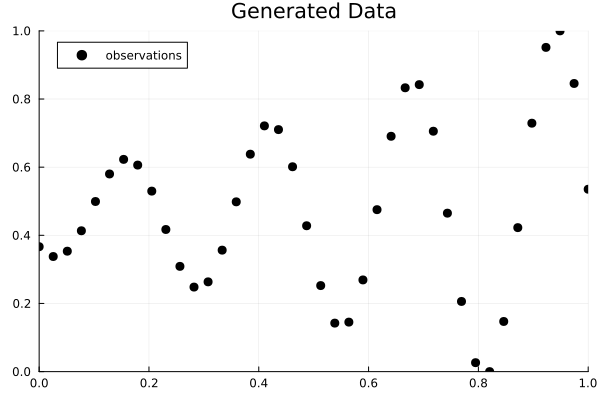

In [30]:
# Generate data from a random GP kernel
fn = function_prior()
xs, ys, fn, (xmin_orig, xmax_orig) = get_data(fn, 40)
println("Ground truth kernel: ", fn)

scatter(xs, ys, xlims=(0, 1), ylims=(0, 1), 
        title="Generated Data", label="observations", 
        color=:black, markersize=5)

## Run Particle Filter with Adaptive Computation

Now we run the GP kernel discovery particle filter with AC allocation.
We track allocation history to see how attention is distributed.

In [31]:
# Configure
num_particles = 10
num_rounds = 25
budget = 80

# Create Task-Driven AC strategy
# This combines:
#   - δˢ (Sensitivity): based on acceptance rates and objective volatility
#   - δᵖ (Decision Relevance): based on particle weights
ac = TaskDrivenAC(
    # Task objective - using posterior score as proxy
    # (could use PredictionObjective with held-out data for true task-driven AC)
    objective = PosteriorObjective(),
    
    # Temperature for importance distribution
    τ = 1.0,
    
    # Decision relevance mode:
    # :competitive - 4w(1-w), particles near decision boundary
    # :weight - favor high-weight particles
    # :exploration - favor low-weight particles
    δπ_mode = :competitive,
    
    # Minimum moves per particle
    jmin = 1
)

# Run with history tracking
traces, allocation_history, total_allocations = gp_particle_filter(
    xs, ys, 
    num_particles, num_rounds, 0, num_particles,
    ac, budget;
    verbose=true,
    return_history=true
)

println("\n=== Final Results ===")
println("Total allocations per particle: ", total_allocations)
println("Mean allocations: ", mean(total_allocations))

=== Task-Driven AC ===
Weights: [0.0, 0.0, 0.997, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
δˢ (sensitivity): [0.693, 0.215, 1.631, 1.318, 0.046, 1.312, 0.747, 1.227, 0.898, 0.695]
δᵖ (decision relevance): [0.0, 0.0, 0.012, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Δ (task relevance): [-23.39, -24.54, -3.94, -4.16, -25.82, -22.75, -14.42, -22.82, -23.13, -11.84]
Importance: [0.0, 0.0, 0.553, 0.447, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Arousal: 80, Allocations: [1, 1, 45, 37, 1, 1, 1, 1, 1, 1] (sum=90)
=== Task-Driven AC ===
Weights: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
δˢ (sensitivity): [0.683, 0.683, 1.312, 1.944, 1.099, 0.979, 0.039, 0.683, 0.683, 0.683]
δᵖ (decision relevance): [0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36]
Δ (task relevance): [-1.4, -1.4, -0.75, -0.36, -0.93, -1.04, -4.26, -1.4, -1.4, -1.4]
Importance: [0.078, 0.078, 0.149, 0.221, 0.125, 0.111, 0.004, 0.078, 0.078, 0.078]
Arousal: 80, Allocations: [7, 7, 13, 19, 11, 10, 1, 7, 7, 7] (sum=89)
=== Task-Driv

## Visualize Allocation History

Let's see how attention was distributed across particles over the inference rounds.

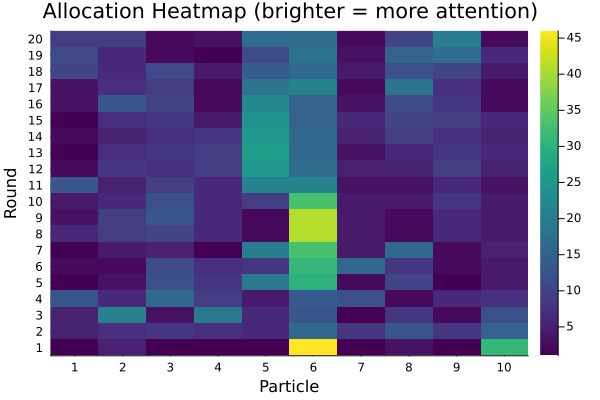

In [25]:
# Convert history to matrix for visualization
alloc_matrix = hcat(allocation_history...)'

# Heatmap of allocations over time
heatmap(alloc_matrix, 
    xlabel="Particle", ylabel="Round",
    title="Allocation Heatmap (brighter = more attention)",
    color=:viridis,
    xticks=1:num_particles,
    yticks=1:num_rounds)

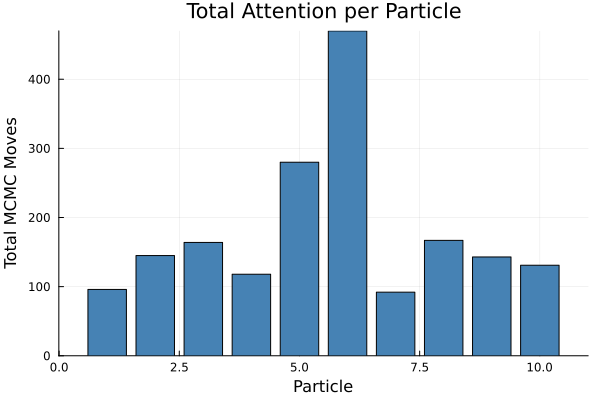

In [26]:
# Bar chart of total allocations per particle
bar(1:num_particles, total_allocations,
    xlabel="Particle", ylabel="Total MCMC Moves",
    title="Total Attention per Particle",
    legend=false,
    color=:steelblue)

## Posterior Visualization with Attention Highlighting

Now the main visualization: plot each particle's GP posterior prediction,
with **line thickness proportional to attention received**.

Thicker lines = more rejuvenation moves = more "work" invested in that particle.

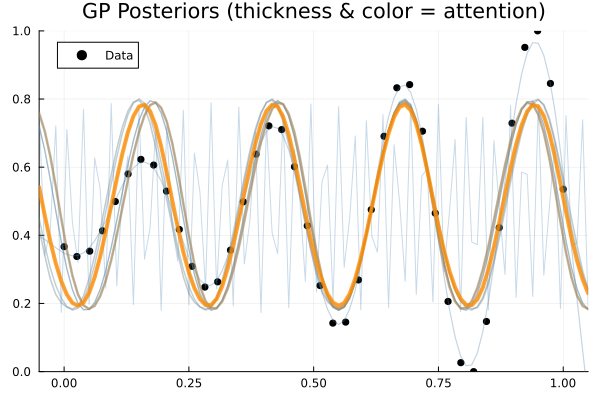

In [32]:
"""
Plot posteriors with attention highlighting.
- Line width proportional to allocation  
- Color gradient from steelblue (low) to darkorange (high)
"""
function plot_posterior_with_attention(traces, xs, ys, allocations; 
                                       title="", xlims=nothing, ylims=nothing)
    n = length(traces)
    
    # Set limits
    if xlims === nothing
        xlims = (minimum(xs)-0.05, maximum(xs)+0.05)
    end
    if ylims === nothing
        ylims = (0, 1)
    end
    
    # Normalize allocations
    min_alloc, max_alloc = extrema(allocations)
    if max_alloc == min_alloc
        norm_allocs = fill(0.5, n)
    else
        norm_allocs = (allocations .- min_alloc) ./ (max_alloc - min_alloc)
    end
    
    # Line widths: 1-4 range (not too thick)
    widths = 1.0 .+ 3.0 .* norm_allocs
    
    # Alpha: lower attention = more transparent
    alphas = 0.3 .+ 0.5 .* norm_allocs
    
    # Start plot with data
    p = scatter(xs, ys, label="Data", color=:black, markersize=4, 
                xlims=xlims, ylims=ylims, title=title)
    
    x_test = collect(range(xlims[1], xlims[2], length=100))
    
    # Sort by allocation so high-attention particles are drawn on top
    order = sortperm(allocations)
    
    # Plot each particle's posterior
    for (j, i) in enumerate(order)
        tr = traces[i]
        kernel = get_retval(tr)
        noise = tr[:noise]
        
        # Posterior predictive mean
        μ, _ = compute_predictive(kernel, noise, xs, ys, x_test)
        
        # Color gradient: blue -> purple -> orange (more perceptually distinct)
        t = norm_allocs[i]
        c = weighted_color_mean(t, colorant"darkorange", colorant"steelblue")
        
        plot!(p, x_test, μ,
              label="",
              linewidth=widths[i],
              alpha=alphas[i],
              color=c)
    end
    
    return p
end

# Quick static plot
final_allocations = allocation_history[end]
plot_posterior_with_attention(traces, xs, ys, final_allocations,
    title="GP Posteriors (thickness & color = attention)")

[ Info: Saved animation to /Users/witt/work/Goal-Conditioned-GP2/demos/tmp.gif


Plots.AnimatedGif("/Users/witt/work/Goal-Conditioned-GP2/demos/tmp.gif")
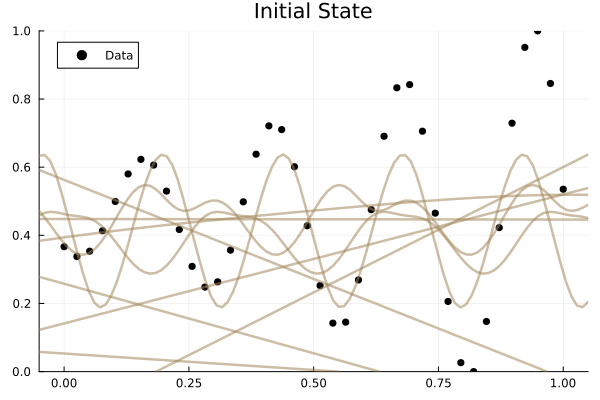

In [33]:
"""
Animate the particle filter with Task-Driven AC, showing attention per round.

Parameters:
- δπ_mode: Decision relevance mode
  - :competitive - 4w(1-w), attention to particles near decision boundary
  - :weight - favor high-weight particles
  - :exploration - favor low-weight particles
- τ: Temperature for importance distribution (lower = more concentrated)
"""
function animate_ac_particle_filter(
    xs::Vector{Float64}, 
    ys::Vector{Float64}, 
    num_particles::Int,
    num_rounds::Int,
    budget::Int;
    δπ_mode::Symbol = :competitive,
    τ::Float64 = 1.0
)
    # Create Task-Driven AC strategy
    ac = TaskDrivenAC(
        objective = PosteriorObjective(),
        τ = τ,
        δπ_mode = δπ_mode,
        jmin = 1
    )
    
    # Initialize
    obs = choicemap(:ys => ys)
    state = Gen.initialize_particle_filter(model, (xs,), obs, num_particles)
    
    # Fixed axis limits
    xlims = (minimum(xs)-0.05, maximum(xs)+0.05)
    ylims = (0, 1)
    
    # Track allocations for animation
    all_allocations = Vector{Vector{Int}}()
    
    # Create animation
    anim = @animate for round in 0:num_rounds
        if round == 0
            # Initial state - uniform "attention"
            allocations = fill(1, num_particles)
            title_str = "Initial State"
        else
            # Get allocations for this round
            allocations = all_allocations[round]
            title_str = "Round $round"
        end
        
        plot_posterior_with_attention(state.traces, xs, ys, allocations;
            title=title_str, xlims=xlims, ylims=ylims)
        
        # Perform rejuvenation for next frame (if not last)
        if round < num_rounds
            # Reset tracking state for this round
            reset_round!(ac, num_particles)
            
            # Compute allocations BEFORE resampling (while scores differentiate particles)
            allocations = compute_allocations(ac, state.traces, state.log_weights, budget)
            push!(all_allocations, copy(allocations))
            
            # Now resample
            Gen.maybe_resample!(state, ess_threshold=num_particles/2)
            
            # Rejuvenate and track acceptance for sensitivity
            for i in 1:num_particles
                for _ in 1:allocations[i]
                    state.traces[i], accepted = mh(
                        state.traces[i],
                        regen_random_subtree_randomness,
                        (),
                        subtree_involution
                    )
                    record_move!(ac, i, accepted)
                    state.traces[i], = mh(state.traces[i], select(:noise))
                end
            end
        end
    end
    
    gif(anim, fps=2)
end

# Run the animation with Task-Driven AC!
# Try different δπ_mode values:
#   :competitive - attention to particles near decision boundary (like MOT paper)
#   :weight - more attention to high-weight particles
#   :exploration - more attention to low-weight particles
animate_ac_particle_filter(xs, ys, num_particles, num_rounds, budget; 
    δπ_mode=:competitive, τ=1.0)

## Decision Relevance Modes

The `δπ_mode` parameter controls *which particles matter* for the task:

| Mode | Formula | Interpretation |
|------|---------|----------------|
| `:competitive` | `4w(1-w)` | Particles near decision boundary (like MOT paper) |
| `:weight` | `w` | High-weight particles = good hypotheses |
| `:exploration` | `1-w` | Low-weight particles = underexplored |

**Key insight from AC paper**: In MOT, targets near distractors need more attention because small perceptual changes could flip the decision. Similarly, for GP discovery, particles with middling weights are "competitive" — small changes might make them winners or losers.

In [43]:
# Compare the three modes side-by-side
println("=== Comparing δπ modes ===\n")

for mode in [:competitive, :weight, :exploration]
    ac_test = TaskDrivenAC(
        objective = PosteriorObjective(),
        τ = 1.0,
        δπ_mode = mode,
        jmin = 1
    )
    
    # Get one round of allocations
    allocs = compute_allocations(ac_test, traces, zeros(length(traces)), budget; verbose=false)
    println("Mode: $mode → allocations: $allocs")
end

=== Comparing δπ modes ===

Mode: competitive → allocations: [7, 1, 1, 11, 16, 11, 34, 6, 1, 1]
Mode: weight → allocations: [7, 1, 1, 11, 16, 11, 34, 6, 1, 1]
Mode: exploration → allocations: [7, 1, 1, 11, 16, 11, 34, 6, 1, 1]


## True Task-Driven AC: Prediction Objective

For genuine task-driven AC, we can define what "success" means explicitly.
For example, with held-out prediction as the task:

```julia
# Split data
train_xs, test_xs = xs[1:15], xs[16:end]
train_ys, test_ys = ys[1:15], ys[16:end]

# Create prediction-driven AC
ac = TaskDrivenAC(
    objective = PredictionObjective(
        held_out_xs = test_xs,
        held_out_ys = test_ys
    ),
    δπ_mode = :competitive,
    τ = 1.0
)
```

This makes AC allocate compute based on:
- **δˢ**: How much do MCMC moves change prediction quality?
- **δᵖ**: How competitive is this particle?

Particles where MCMC changes predictions more = need more attention to stabilize.

Training points: 28
Extrapolation points: 12
Training range: (0.0, 0.6923076923076923)
Extrapolation range: (0.717948717948718, 1.0)


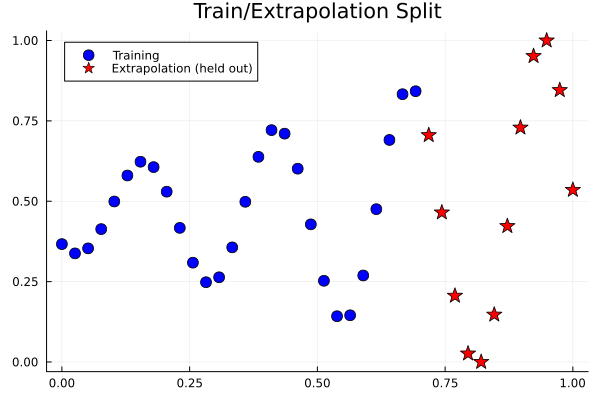

In [44]:
# Generate data with known extrapolation region
# We'll use some data for training, and hold out the right side for extrapolation

# Training data: left portion
train_mask = xs .< 0.7
train_xs = xs[train_mask]
train_ys = ys[train_mask]

# Extrapolation data: right portion (ground truth we're trying to predict)
extrap_mask = xs .>= 0.7
extrap_xs = xs[extrap_mask]
extrap_ys = ys[extrap_mask]

println("Training points: $(length(train_xs))")
println("Extrapolation points: $(length(extrap_xs))")
println("Training range: $(extrema(train_xs))")
println("Extrapolation range: $(extrema(extrap_xs))")

# Visualize the split
scatter(train_xs, train_ys, label="Training", color=:blue, markersize=6)
scatter!(extrap_xs, extrap_ys, label="Extrapolation (held out)", color=:red, 
         marker=:star, markersize=8, title="Train/Extrapolation Split")

In [48]:
# Create Extrapolation-Driven AC
# This allocates compute based on extrapolation performance!

extrap_ac = TaskDrivenAC(
    # The task: predict well beyond training range
    objective = ExtrapolationObjective(
        extrap_xs = extrap_xs,
        extrap_ys = extrap_ys
    ),
    
    # Temperature for allocation spread
    τ = 1.0,
    
    # Decision relevance: favor competitive particles
    δπ_mode = :competitive,
    
    # Minimum moves per particle
    jmin = 1
)

println("Running particle filter with EXTRAPOLATION objective...")
println("Particles that predict well beyond training range will get more attention!\n")

# Run on training data only
extrap_traces, extrap_history, extrap_total = gp_particle_filter(
    train_xs, train_ys,  # Train only on left portion!
    num_particles, num_rounds, 0, num_particles,
    extrap_ac, budget;
    verbose=true,
    return_history=true
)

println("\n=== Extrapolation-Driven Results ===")
println("Total allocations: $extrap_total")

Running particle filter with EXTRAPOLATION objective...
Particles that predict well beyond training range will get more attention!

=== Task-Driven AC ===
Weights: [0.0, 0.0, 0.0, 0.0, 0.027, 0.0, 0.973, 0.0, 0.0, 0.0]
δˢ (sensitivity): [0.464, 0.294, 2.554, 0.565, 0.466, 0.366, 0.471, 0.617, 0.568, 1.256]
δᵖ (decision relevance): [0.0, 0.0, 0.0, 0.0, 0.103, 0.0, 0.103, 0.0, 0.0, 0.0]
Δ (task relevance): [-21.43, -24.24, -15.54, -17.5, -3.04, -22.12, -3.02, -23.5, -23.52, -10.61]
Importance: [0.0, 0.0, 0.0, 0.0, 0.497, 0.0, 0.503, 0.0, 0.0, 0.0]
Arousal: 80, Allocations: [1, 1, 1, 1, 41, 1, 41, 1, 1, 1] (sum=90)
=== Task-Driven AC ===
Weights: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
δˢ (sensitivity): [0.344, 0.344, 0.344, 0.299, 2.999, 0.295, 0.295, 0.344, 0.392, 0.344]
δᵖ (decision relevance): [0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36]
Δ (task relevance): [-2.09, -2.09, -2.09, -2.23, 0.08, -2.24, -2.24, -2.09, -1.96, -2.09]
Importance: [0.057, 0.057, 0.057

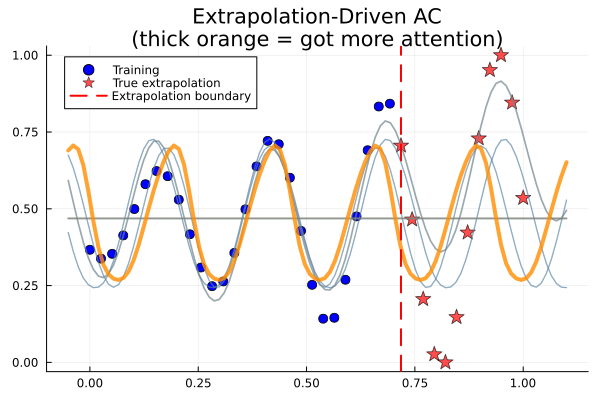

In [49]:
# Visualize extrapolation results
# Show how well each particle extrapolates beyond training

function plot_extrapolation_results(traces, train_xs, train_ys, extrap_xs, extrap_ys, 
                                    allocations; title="")
    p = scatter(train_xs, train_ys, label="Training", color=:blue, markersize=5)
    scatter!(p, extrap_xs, extrap_ys, label="True extrapolation", color=:red, 
             marker=:star, markersize=8, alpha=0.7)
    
    # Normalize allocations for visualization
    min_alloc, max_alloc = extrema(allocations)
    if max_alloc > min_alloc
        norm_allocs = (allocations .- min_alloc) ./ (max_alloc - min_alloc)
    else
        norm_allocs = fill(0.5, length(allocations))
    end
    
    # Full x range for predictions
    x_all = vcat(train_xs, extrap_xs)
    x_test = collect(range(minimum(x_all)-0.05, maximum(x_all)+0.1, length=100))
    
    # Sort by allocation (plot low-attention first)
    order = sortperm(allocations)
    
    for (j, i) in enumerate(order)
        tr = traces[i]
        kernel = get_retval(tr)
        noise = tr[:noise]
        
        μ, _ = compute_predictive(kernel, noise, train_xs, train_ys, x_test)
        
        t = norm_allocs[i]
        width = 1.0 + 3.0 * t
        c = weighted_color_mean(t, colorant"darkorange", colorant"steelblue")
        
        plot!(p, x_test, μ, label="", linewidth=width, alpha=0.4+0.4*t, color=c)
    end
    
    # Mark extrapolation region
    vline!(p, [minimum(extrap_xs)], color=:red, linestyle=:dash, 
           label="Extrapolation boundary", linewidth=2)
    
    plot!(p, title=title, xlims=(minimum(x_all)-0.1, maximum(x_all)+0.15))
    return p
end

# Show results
plot_extrapolation_results(
    extrap_traces, train_xs, train_ys, extrap_xs, extrap_ys,
    extrap_total;
    title="Extrapolation-Driven AC\n(thick orange = got more attention)"
)

In [50]:
# Compare: Posterior-driven vs Extrapolation-driven allocation
# Which particles get attention under each objective?

println("=== Comparing Objectives ===\n")

# Same particles, different objectives
for (name, objective) in [
    ("Posterior (log-likelihood)", PosteriorObjective()),
    ("Extrapolation (MSE)", ExtrapolationObjective(extrap_xs=extrap_xs, extrap_ys=extrap_ys)),
    ("Extrapolation Uncertainty", ExtrapolationUncertaintyObjective(n_extrap_points=10))
]
    test_ac = TaskDrivenAC(objective=objective, τ=1.0, δπ_mode=:weight, jmin=1)
    
    # Evaluate objective for each trace
    obj_values = [evaluate_objective(objective, tr) for tr in extrap_traces]
    
    println("$name:")
    println("  Objective values: $(round.(obj_values, digits=2))")
    
    # Get allocations
    allocs = compute_allocations(test_ac, extrap_traces, zeros(length(extrap_traces)), budget; verbose=false)
    println("  Allocations: $allocs")
    println()
end

=== Comparing Objectives ===

Posterior (log-likelihood):
  Objective values: [2.69, 2.22, 2.22, 1.35, 3.76, 10.21, 2.69, 10.21, -2.12, -2.12]
  Allocations: [2, 3, 3, 6, 3, 20, 2, 20, 15, 15]

Extrapolation (MSE):
  Objective values: [-0.08, -0.04, -0.04, -0.11, -0.13, -0.04, -0.08, -0.04, -0.11, -0.11]
  Allocations: [1, 10, 10, 10, 14, 12, 1, 12, 10, 10]

Extrapolation Uncertainty:
  Objective values: [-0.05, -0.07, -0.07, -0.03, -0.03, -0.02, -0.05, -0.02, -0.04, -0.04]
  Allocations: [6, 16, 16, 6, 9, 13, 6, 13, 3, 3]



---

## Academic Contribution

This implementation adapts the **Adaptive Computation** framework (Vul et al.) from Multiple Object Tracking to **GP kernel discovery**.

### Novel Contributions

1. **Task-Driven Structure Learning**: First application of AC to symbolic/compositional hypothesis search
   
2. **Sensitivity for Discrete Structures**: Measuring how MCMC on discrete kernel structures affects continuous prediction quality

3. **Decision Relevance for Model Selection**: Adapting the `4w(1-w)` insight to SMC-based structure search

### Potential Paper Directions

- **"Adaptive Computation for Bayesian Program Synthesis"**: Generalizing AC beyond perception to structure/program inference
- **"Resource-Rational Structure Learning"**: Connecting AC to bounded rationality in model discovery  
- **"Goal-Conditioned GP Discovery"**: User specifies task → AC allocates accordingly

[ Info: Saved animation to /Users/witt/work/Goal-Conditioned-GP2/demos/tmp.gif


Plots.AnimatedGif("/Users/witt/work/Goal-Conditioned-GP2/demos/tmp.gif")
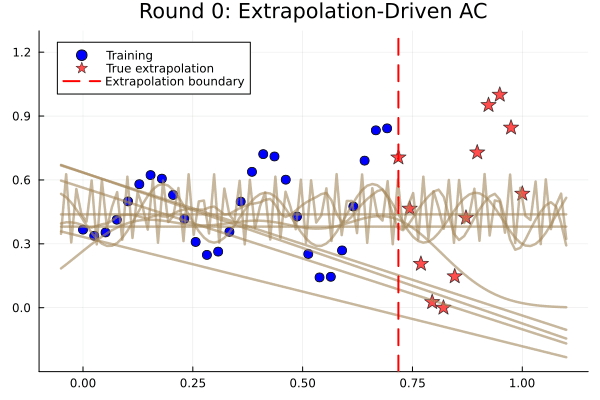

In [51]:
# Animation with Extrapolation Objective
# Watch how AC allocates based on extrapolation performance over time

function animate_extrapolation_ac(
    train_xs, train_ys, extrap_xs, extrap_ys,
    num_particles, num_rounds, budget
)
    # Create extrapolation-driven AC
    ac = TaskDrivenAC(
        objective = ExtrapolationObjective(extrap_xs=extrap_xs, extrap_ys=extrap_ys),
        τ = 1.0,
        δπ_mode = :competitive,
        jmin = 1
    )
    
    # Initialize particle filter
    obs = choicemap(:ys => train_ys)
    state = Gen.initialize_particle_filter(model, (train_xs,), obs, num_particles)
    
    all_allocations = Vector{Vector{Int}}()
    x_all = vcat(train_xs, extrap_xs)
    xlims = (minimum(x_all)-0.1, maximum(x_all)+0.15)
    ylims = (minimum(vcat(train_ys, extrap_ys))-0.3, maximum(vcat(train_ys, extrap_ys))+0.3)
    
    anim = @animate for round in 0:num_rounds
        allocations = round == 0 ? fill(1, num_particles) : all_allocations[round]
        
        p = plot_extrapolation_results(
            state.traces, train_xs, train_ys, extrap_xs, extrap_ys, allocations;
            title="Round $round: Extrapolation-Driven AC"
        )
        plot!(p, xlims=xlims, ylims=ylims)
        
        if round < num_rounds
            reset_round!(ac, num_particles)
            allocations = compute_allocations(ac, state.traces, state.log_weights, budget)
            push!(all_allocations, copy(allocations))
            
            Gen.maybe_resample!(state, ess_threshold=num_particles/2)
            
            for i in 1:num_particles
                for _ in 1:allocations[i]
                    state.traces[i], accepted = mh(
                        state.traces[i],
                        regen_random_subtree_randomness, (), subtree_involution
                    )
                    record_move!(ac, i, accepted)
                    state.traces[i], = mh(state.traces[i], select(:noise))
                end
            end
        end
    end
    
    gif(anim, fps=2)
end

# Run it!
animate_extrapolation_ac(train_xs, train_ys, extrap_xs, extrap_ys, 
                         num_particles, 15, budget)

---

## Academic Contribution

This implementation adapts the **Adaptive Computation** framework (Vul et al.) from Multiple Object Tracking to **GP kernel discovery**.

### Novel Contributions

1. **Task-Driven Structure Learning**: First application of AC to symbolic/compositional hypothesis search
   
2. **Sensitivity for Discrete Structures**: Measuring how MCMC on discrete kernel structures affects continuous prediction quality

3. **Decision Relevance for Model Selection**: Adapting the `4w(1-w)` insight to SMC-based structure search

### Potential Paper Directions

- **"Adaptive Computation for Bayesian Program Synthesis"**: Generalizing AC beyond perception to structure/program inference
- **"Resource-Rational Structure Learning"**: Connecting AC to bounded rationality in model discovery  
- **"Goal-Conditioned GP Discovery"**: User specifies task → AC allocates accordingly

---

## Academic Contribution

This implementation adapts the **Adaptive Computation** framework (Vul et al.) from Multiple Object Tracking to **GP kernel discovery**.

### Novel Contributions

1. **Task-Driven Structure Learning**: First application of AC to symbolic/compositional hypothesis search
   
2. **Sensitivity for Discrete Structures**: Measuring how MCMC on discrete kernel structures affects continuous prediction quality

3. **Decision Relevance for Model Selection**: Adapting the `4w(1-w)` insight to SMC-based structure search

### Potential Paper Directions

- **"Adaptive Computation for Bayesian Program Synthesis"**: Generalizing AC beyond perception to structure/program inference
- **"Resource-Rational Structure Learning"**: Connecting AC to bounded rationality in model discovery  
- **"Goal-Conditioned GP Discovery"**: User specifies task → AC allocates accordingly

## Comparison: Uniform vs Adaptive Allocation

Let's run the same inference with uniform allocation to compare.

In [40]:
# Run with Uniform allocation
uniform_alloc = UniformAllocation()  # Don't name it 'uniform' - shadows Gen.uniform!

traces_uniform, allocation_history_uniform, total_uniform = gp_particle_filter(
    xs, ys, 
    num_particles, num_rounds, 0, num_particles,
    uniform_alloc, budget;
    verbose=false,
    return_history=true
)

println("Uniform allocations per particle: ", total_uniform)
println("(All equal, as expected)")

Uniform allocations per particle: [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
(All equal, as expected)


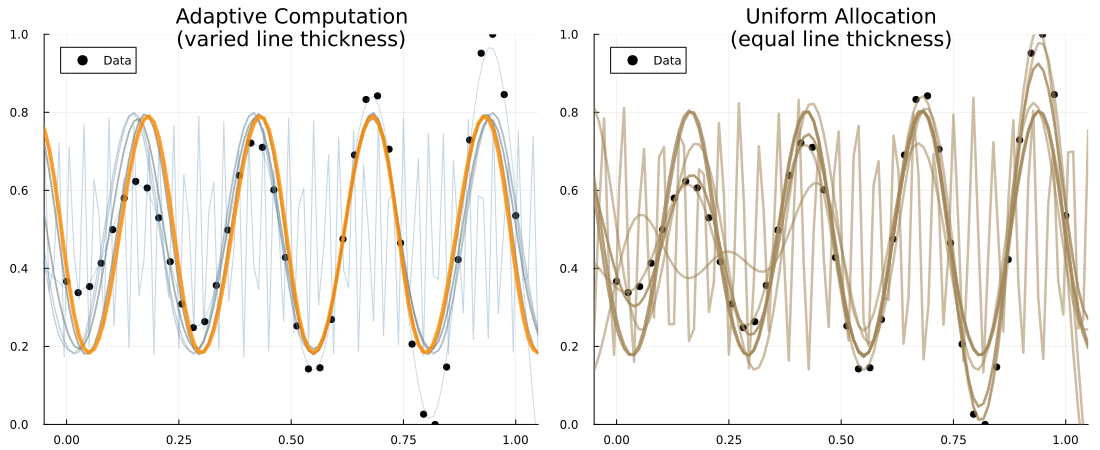

In [41]:
# Side-by-side comparison
p1 = plot_posterior_with_attention(traces, xs, ys, total_allocations,
    title="Adaptive Computation\n(varied line thickness)")

p2 = plot_posterior_with_attention(traces_uniform, xs, ys, total_uniform,
    title="Uniform Allocation\n(equal line thickness)")

plot(p1, p2, layout=(1,2), size=(1100, 450))

## Interpretation

In the AC visualization:
- **Thick lines** = particles that received more rejuvenation moves
- These are particles with high **task relevance** (competitive weights AND still exploring)

The adaptive strategy focuses compute where it matters most:
- Particles near the decision boundary (neither clearly best nor clearly worst)
- Particles still showing movement (high acceptance rate = still improving)

In contrast, uniform allocation spreads compute equally regardless of particle quality.

## Detailed View: Per-Round Allocation Evolution

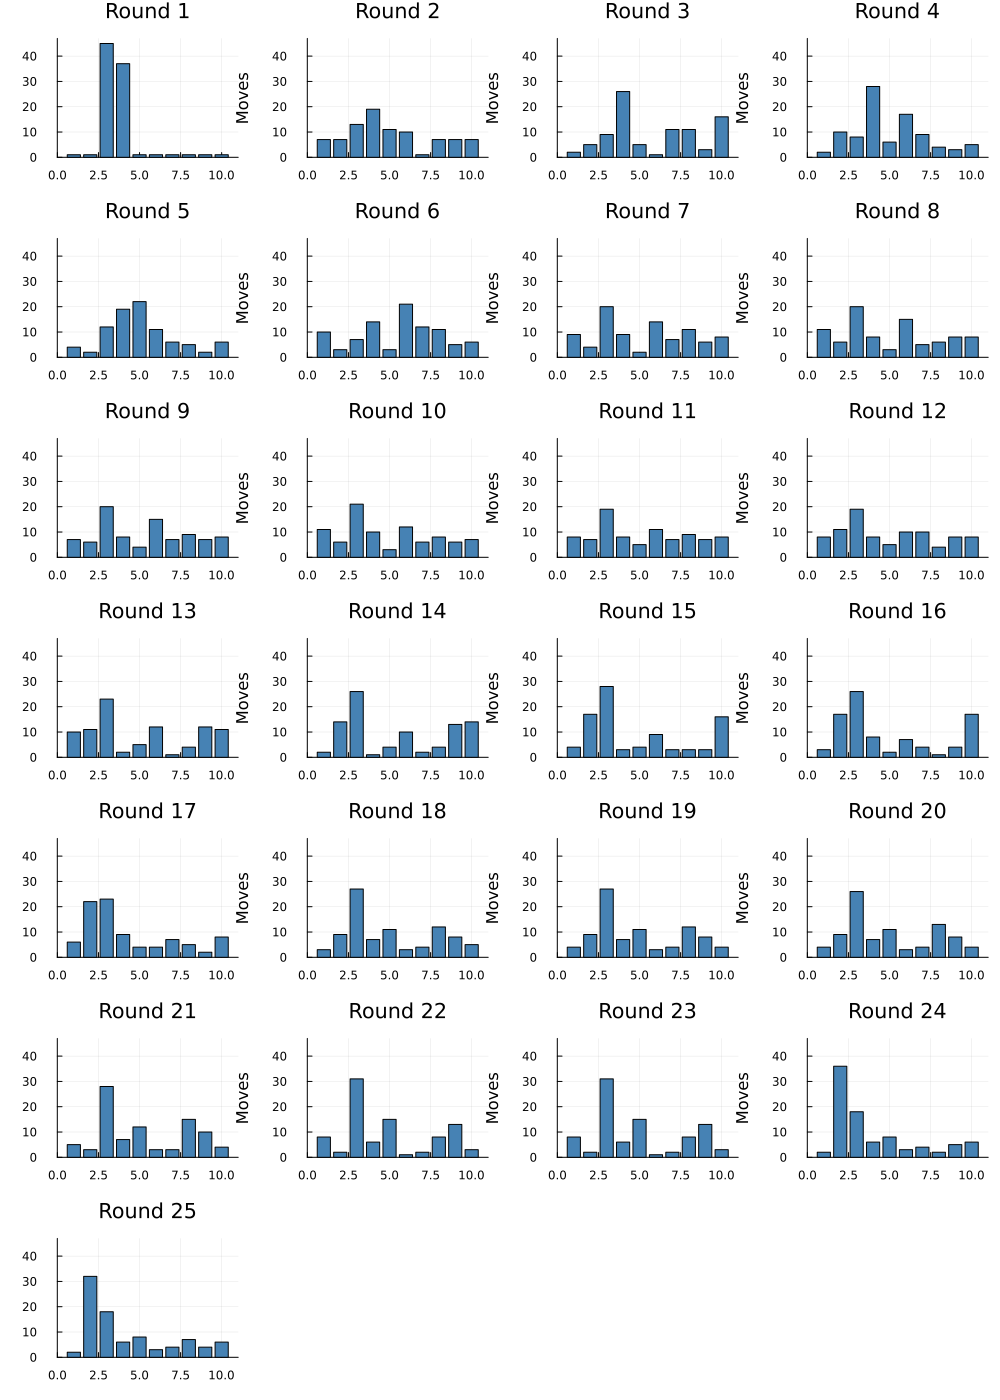

In [42]:
# Show allocation distribution per round
plots = []
for (r, allocs) in enumerate(allocation_history)
    p = bar(1:num_particles, allocs,
            xlabel="", ylabel="Moves",
            title="Round $r",
            legend=false,
            ylims=(0, maximum(maximum.(allocation_history)) + 2),
            color=:steelblue)
    push!(plots, p)
end

# Arrange in grid
n_cols = min(4, length(plots))
n_rows = ceil(Int, length(plots) / n_cols)
plot(plots..., layout=(n_rows, n_cols), size=(250*n_cols, 200*n_rows))

## Summary

This demo shows how Adaptive Computation dynamically allocates rejuvenation moves:

1. **Early rounds**: More uniform allocation (less history to differentiate)
2. **Later rounds**: Concentrated attention on "interesting" particles
3. **Visualization**: Line thickness reveals where compute was invested

The key insight: AC automatically identifies which hypotheses deserve more refinement,
focusing computational resources where they have the most impact on the posterior.